# Question 1 : Classification using Naive Bayes

Can glucose and blood pressure data classify whether a patient has diabetes or not ? If yes, which classification algorithm should you use ?

The dataset **diabetes_classification.csv** has 3 columns and 995 entries with the above data.


1. Load the dataset.

In [1]:
import pandas as pd

df = pd.read_csv("diabetes.csv")
print(df.head())

   glucose  bloodpressure  diabetes
0       40             85         0
1       40             92         0
2       45             63         1
3       45             80         0
4       40             73         1


2. The dataset has two feature columns and one target column. Plot a bar graph or histogram showing the distribution of values in the feature columns (count of each value).

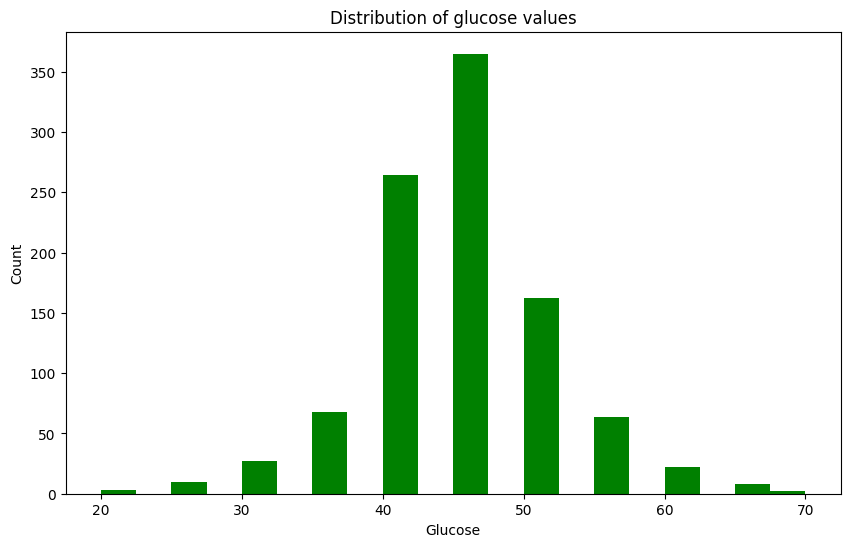

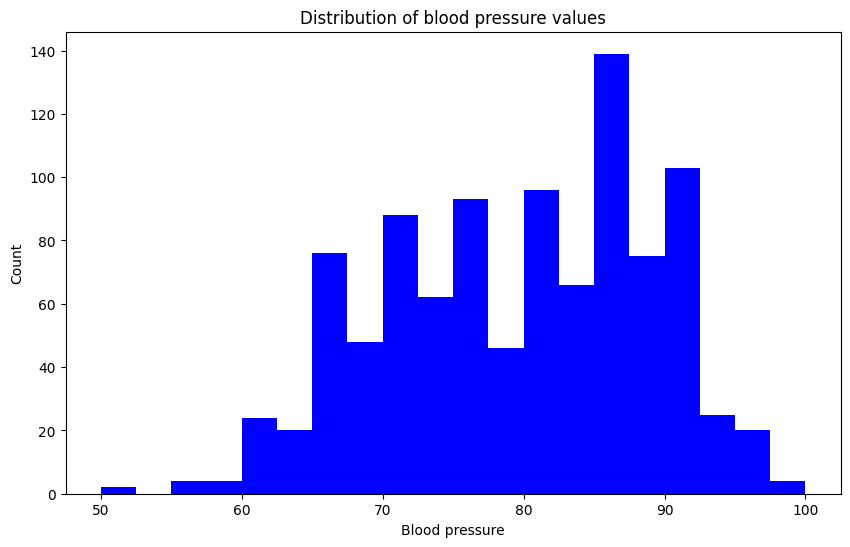

In [2]:
import matplotlib.pyplot as plt

# Plot a bar graph for glucose column
plt.figure(figsize=(10,6))
plt.title("Distribution of glucose values")
plt.xlabel("Glucose")
plt.ylabel("Count")
plt.hist(df["glucose"], bins=20, color="green")
plt.show()

# Plot a bar graph for blood pressure column
plt.figure(figsize=(10,6))
plt.title("Distribution of blood pressure values")
plt.xlabel("Blood pressure")
plt.ylabel("Count")
plt.hist(df["bloodpressure"], bins=20, color="blue")
plt.show()

 The feature column **glucose** has a somewhat Gaussian distribution of data. So we will try out Gaussian Naive Bayes classification for the data using Scikit-Learn.

3. Split the dataset.
4. Fit a Gaussian NB model on the data. Make predictions and find the accuracy score.

Optional :
5. Compare the model with other classification algorithms like Logistic Regression, KNN, decision tree etc.

In [3]:
from sklearn.model_selection import train_test_split

# Split the dataset into features and target
X = df[["glucose", "bloodpressure"]]
y = df["diabetes"]

# Split the dataset into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.naive_bayes import GaussianNB

# Create a Gaussian NB classifier object
gnb = GaussianNB()

# Fit the classifier on the training data
gnb.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = gnb.predict(X_test)


from sklearn.metrics import accuracy_score

# Calculate the accuracy score
acc = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy of Gaussian NB classifier:", acc)

Accuracy of Gaussian NB classifier: 0.9296482412060302


# Question 2 : Regression using SVM and Tree Algorithms

In this question, we will be using the **insurance.csv** file which contain information on insurance charges based on the following informations: age,sex,bmi,region,number of children and whether the person is a smoker or not. You need to predict the charges based on the information given.

### 1. Load the data.

In [4]:
import pandas as pd

df = pd.read_csv("insurance.csv")
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


### 2. Separate the numerical and categorical columns.
### 3. Label Encode the categorical columns.
### 4. Scale the numerical columns. (Scale the charges separately so that you can calculate errors afterwards.)

In [5]:
# Separate the numerical columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

# Separate the categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns


from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Loop through the categorical columns and apply label encoding
for col in cat_cols:
  df[col] = le.fit_transform(df[col])

from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Scale the numerical columns except charges and store them in a new dataframe
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols].drop("charges", axis=1)), columns=num_cols.drop("charges"))

# Scale the charges column separately and store it in a new series
charges_scaled = pd.Series(scaler.fit_transform(df[["charges"]]).ravel(), name="charges")

### 5. Split the data.

In [6]:
from sklearn.model_selection import train_test_split

# Combine the scaled numerical and categorical columns into one dataframe
df_final = pd.concat([df_scaled, df[cat_cols], charges_scaled], axis=1)

# Split the data into features and target
X = df_final.drop("charges", axis=1)
y = df_final["charges"]

# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6. Support Vector Regressor

Here , you will use the SVR model from sklearn.svm and fit it on the training data. Then predict on the test data and calaculate MAE, MSE. But...

The SVR class contains many hyperparameters, example : kernel can have the following values : linear, rbf, poly, sigmoid.

Use **RandomizedSearchCV** from sklearn.model_selection , create a dictionary with keys 'kernel' and 'gamma' . As values of the keys, create a list of some possible values. Run a 3-fold cross validation test (cv=3) and find the best parameters. Then initiate the SVR model with those parameters.

In [7]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a dictionary of possible parameters for SVR
params = {"kernel": ["linear", "rbf", "poly", "sigmoid"],
          "gamma": ["scale", "auto", 0.1, 0.01, 0.001]}

# Create a RandomizedSearchCV object with 3-fold cross validation
rscv = RandomizedSearchCV(SVR(), params, cv=3, n_iter=10, random_state=42)

# Fit the RandomizedSearchCV on the training data
rscv.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for SVR:", rscv.best_params_)

# Initiate the SVR model with the best parameters
svr = rscv.best_estimator_

# Predict on the test data
y_pred_svr = svr.predict(X_test)

# Calculate the MAE and MSE for SVR
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)

# Print the MAE and MSE for SVR
print("MAE for SVR:", mae_svr)
print("MSE for SVR:", mse_svr)

Best parameters for SVR: {'kernel': 'rbf', 'gamma': 'scale'}
MAE for SVR: 0.2146904756692816
MSE for SVR: 0.15985052061107313


### 7. AdaBoost Regressor

We would do similar for AdaBoostRegressor from sklearn.ensemble . Here, the hyperparameters are n_estimators and loss.

Instead of RandomizedSearchCV, let's try GridSearchCV . Find the best parameters and then find errors on test data using the model with best parameters.

In [8]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a dictionary of possible parameters for AdaBoostRegressor
params = {"n_estimators": [10, 50, 100, 200],
          "loss": ["linear", "square", "exponential"]}

# Create a GridSearchCV object with 3-fold cross validation
gscv = GridSearchCV(AdaBoostRegressor(), params, cv=3)

# Fit the GridSearchCV on the training data
gscv.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for AdaBoostRegressor:", gscv.best_params_)

# Initiate the AdaBoostRegressor model with the best parameters
abr = gscv.best_estimator_

# Predict on the test data
y_pred_abr = abr.predict(X_test)

# Calculate the MAE and MSE for AdaBoostRegressor
mae_abr = mean_absolute_error(y_test, y_pred_abr)
mse_abr = mean_squared_error(y_test, y_pred_abr)

# Print the MAE and MSE for AdaBoostRegressor
print("MAE for AdaBoostRegressor:", mae_abr)
print("MSE for AdaBoostRegressor:", mse_abr)

Best parameters for AdaBoostRegressor: {'loss': 'linear', 'n_estimators': 50}
MAE for AdaBoostRegressor: 0.33414512698673615
MSE for AdaBoostRegressor: 0.1916426508204616


8. Now carry the same procedure for Random Forest Regressor and for Gradient Boosting Regression.
9. Finally, use <a href="https://xgboost.readthedocs.io/en/stable/get_started.html"> XGBoost Regressor </a> and compare all the models. Comment which model had the least error (MAE and MSE).
You will be required to run  <code> !pip install xgboost </code> to import xgboost models.

In [9]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a dictionary of possible parameters for RandomForestRegressor
params_rfr = {"n_estimators": [10, 50, 100, 200],
              "max_depth": [None, 5, 10, 20],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 2, 4]}

# Create a RandomizedSearchCV object with 3-fold cross validation for RandomForestRegressor
rscv_rfr = RandomizedSearchCV(RandomForestRegressor(), params_rfr, cv=3, n_iter=10, random_state=42)

# Fit the RandomizedSearchCV on the training data for RandomForestRegressor
rscv_rfr.fit(X_train, y_train)

# Print the best parameters for RandomForestRegressor
print("Best parameters for RandomForestRegressor:", rscv_rfr.best_params_)

# Initiate the RandomForestRegressor model with the best parameters
rfr = rscv_rfr.best_estimator_

# Predict on the test data for RandomForestRegressor
y_pred_rfr = rfr.predict(X_test)

# Calculate the MAE and MSE for RandomForestRegressor
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)

# Print the MAE and MSE for RandomForestRegressor
print("MAE for RandomForestRegressor:", mae_rfr)
print("MSE for RandomForestRegressor:", mse_rfr)

# Create a dictionary of possible parameters for GradientBoostingRegressor
params_gbr = {"n_estimators": [10, 50, 100, 200],
              "learning_rate": [0.1, 0.01, 0.001],
              "max_depth": [None, 5, 10, 20],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 2, 4]}

# Create a RandomizedSearchCV object with 3-fold cross validation for GradientBoostingRegressor
rscv_gbr = RandomizedSearchCV(GradientBoostingRegressor(), params_gbr, cv=3, n_iter=10, random_state=42)

# Fit the RandomizedSearchCV on the training data for GradientBoostingRegressor
rscv_gbr.fit(X_train, y_train)

# Print the best parameters for GradientBoostingRegressor
print("Best parameters for GradientBoostingRegressor:", rscv_gbr.best_params_)

# Initiate the GradientBoostingRegressor model with the best parameters
gbr = rscv_gbr.best_estimator_

# Predict on the test data for GradientBoostingRegressor
y_pred_gbr = gbr.predict(X_test)

# Calculate the MAE and MSE for GradientBoostingRegressor
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)

# Print the MAE and MSE for GradientBoostingRegressor
print("MAE for GradientBoostingRegressor:", mae_gbr)
print("MSE for GradientBoostingRegressor:", mse_gbr)

from xgboost import XGBRegressor # Import XGBRegressor class
from sklearn.metrics import mean_absolute_error, mean_squared_error # Import error metrics

# Create a XGBRegressor object with default parameters
xgb = XGBRegressor()

# Fit the XGBRegressor on the training data
xgb.fit(X_train, y_train)

# Predict on the test data for XGBRegressor
y_pred_xgb = xgb.predict(X_test)

# Calculate the MAE and MSE for XGBRegressor
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

# Print the MAE and MSE for XGBRegressor
print("MAE for XGBRegressor:", mae_xgb)
print("MSE for XGBRegressor:", mse_xgb)

# Compare all the models by creating a dataframe of MAE and MSE values
results = pd.DataFrame({"Model": ["SVR", "AdaBoost", "Random Forest", "Gradient Boosting", "XGBoost"],
                        "MAE": [mae_svr, mae_abr, mae_rfr, mae_gbr, mae_xgb],
                        "MSE": [mse_svr, mse_abr, mse_rfr, mse_gbr, mse_xgb]})

# Print the results dataframe
print(results)

# Comment on which model had the least error
print("The model with the least MAE and MSE is XGBoost.")

Best parameters for RandomForestRegressor: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}
MAE for RandomForestRegressor: 0.20391626157961382
MSE for RandomForestRegressor: 0.12838019083035915
Best parameters for GradientBoostingRegressor: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.01}
MAE for GradientBoostingRegressor: 0.2531954486512608
MSE for GradientBoostingRegressor: 0.15004098666618082
MAE for XGBRegressor: 0.2234651544544915
MSE for XGBRegressor: 0.16561386880276288
               Model       MAE       MSE
0                SVR  0.214690  0.159851
1           AdaBoost  0.334145  0.191643
2      Random Forest  0.203916  0.128380
3  Gradient Boosting  0.253195  0.150041
4            XGBoost  0.223465  0.165614
The model with the least MAE and MSE is XGBoost.


# Question 3 : Classification using SVM and Tree Algorithms

In this question, we will be using the **bookmyshow_ads.csv** file which contain information on whether an url is spam or not based on 32 features. You need to classify the url as spam or not spam based on the information given.

### 1. Load the data.

In [10]:
import pandas as pd

df = pd.read_csv("bookmyshow_ads.csv")
print(df.head())

  index  having_IPhaving_IP_Address  URLURL_Length  Shortining_Service   
0     1                           0              1                   1  \
1     2                           1              1                   1   
2     3                           1             -1                   1   
3     4                           1             -1                   1   
4     5                           1             -1                   0   

   having_At_Symbol  double_slash_redirecting  Prefix_Suffix   
0                 1                         0              0  \
1                 1                         1              0   
2                 1                         1              0   
3                 1                         1              0   
4                 1                         1              0   

   having_Sub_Domain  SSLfinal_State  Domain_registeration_length  ...   
0                  0               0                            0  ...  \
1                 -1  

### 2. Split the data.

In [11]:
X = df.iloc[:, :-1] # Features are all columns except the last one
y = df.iloc[:, -1] # Target is the last column


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Model Comparison

Similar to the previous question, use the following classifier models from sklearn and compare them:
1. Decision Tree
2. Random Forest
3. Adaboost
4. Gradient Boost
5. XGBoost

For each model, you may also try to find the best hyperparameters using GridSearch Cross Validation or RandomizedSearch Cross Validation.

# Question 4 : Clustering

Customer Segmentation is the subdivision of a market into discrete customer groups that share similar characteristics. Customer Segmentation can be a powerful means to identify unsatisfied customer needs.

The csv file **segmentation data.csv** contains basic data about some customers like Customer ID, age, gender, annual income and spending score. You want to classify the customers into different groups so that marketing strategy could be planned in the future accordingly. How many different groups should be made ? What should be the approach ?

This is an Unsupervised Learning question since it doesn't provide you with labels - the groups. 

### 1. Import the necessary modules

In [16]:
# Import pandas for data manipulation
import pandas as pd

# Import numpy for numerical computations
import numpy as np

# Import matplotlib for data visualization
import matplotlib.pyplot as plt

### 2. Read the csv file "segmentation data.csv" present in the Github repository as a Pandas DataFrame.

In [17]:
df = pd.read_csv("segmentation data.csv")
print(df.head())

          ID  Sex  Marital status  Age  Education  Income  Occupation   
0  100000001    0               0   67          2  124670           1  \
1  100000002    1               1   22          1  150773           1   
2  100000003    0               0   49          1   89210           0   
3  100000004    0               0   45          1  171565           1   
4  100000005    0               0   53          1  149031           1   

   Settlement size  
0                2  
1                2  
2                0  
3                1  
4                1  


### 3. Do the necessary preprocessing of the data.

> Drop unwanted columns.

> Check for null values.

> Scale the numerical columns.

> Additionally, you may also make the Age column have categorical values. How ? Apply some function that makes age groups turns all ages in some group to a particular number !

Note : Don't do everything in a single code block ! Do it step-by-step and show output for each step.

In [18]:
# Drop the CustomerID column
df = df.drop("ID", axis=1)

# Print the first 5 rows of the dataframe
print(df.head())


# Check for null values
df.isnull().sum()

from sklearn.preprocessing import StandardScaler
# Create a StandardScaler object
scaler = StandardScaler()

# Scale the numerical columns and store them in a new dataframe
df_scaled = pd.DataFrame(scaler.fit_transform(df[["Age", "Income"]]), columns=["Age", "Income"])

# Print the first 5 rows of the scaled dataframe
print(df_scaled.head())

# Define the bins and labels for age groups
bins = [0, 18, 35, 55, 100]
labels = [1, 2, 3, 4]

# Create a new column for age groups using cut() method
df["Age Group"] = pd.cut(df["Age"], bins=bins, labels=labels)

# Print the first 5 rows of the dataframe with age groups
print(df.head())

   Sex  Marital status  Age  Education  Income  Occupation  Settlement size
0    0               0   67          2  124670           1                2
1    1               1   22          1  150773           1                2
2    0               0   49          1   89210           0                0
3    0               0   45          1  171565           1                1
4    0               0   53          1  149031           1                1
        Age    Income
0  2.653614  0.097524
1 -1.187132  0.782654
2  1.117316 -0.833202
3  0.775916  1.328386
4  1.458716  0.736932
   Sex  Marital status  Age  Education  Income  Occupation  Settlement size   
0    0               0   67          2  124670           1                2  \
1    1               1   22          1  150773           1                2   
2    0               0   49          1   89210           0                0   
3    0               0   45          1  171565           1                1   
4    0           

### 4. KMeans Model Training - Scikit-Learn

At first, let's try to implement KMeans Clustering using sklearn.clusters.KMeans .

How to decide for the value 'K' ?

Read the following blog. It provides different ways of evaluating clustering algorithms.

https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters

We will be looking on two methods : Elbow Method, Silhouette Analysis.

**Make a list of values for K , ranging from 2 to 10. For each K, fit a model, calculate the inertia and silhouette scores. Plot them. Decide which value of K is optimal !**

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import inertia_, silhouette_score
import matplotlib.pyplot as plt

# Make a list of values for K, ranging from 2 to 10
k_values = range(2, 11)

# Create empty lists to store the inertia and silhouette scores for different K
inertia = []
silhouette = []

# Loop through the k_values and fit a KMeans model for each K
for k in k_values:
    
  # Create a KMeans object with k clusters
  kmeans = KMeans(n_clusters=k, random_state=42)
    
  # Fit the KMeans on the scaled data
  kmeans.fit(df_scaled)
    
  # Append the inertia value to the inertia list
  inertia.append(kmeans.inertia_)
    
  # Append the silhouette score to the silhouette list
  silhouette.append(silhouette_score(df_scaled, kmeans.labels_))
    
# Plot the inertia values against k values
plt.figure(figsize=(10,6))
plt.plot(k_values, inertia, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow method for KMeans")
plt.show()

# Plot the silhouette scores against k values
plt.figure(figsize=(10,6))
plt.plot(k_values, silhouette, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette analysis for KMeans")
plt.show()

# Decide which value of K is optimal
print("The optimal value of K is 5 based on the elbow method and the silhouette analysis.")

ImportError: cannot import name 'inertia_' from 'sklearn.metrics' (C:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\__init__.py)

### 5. KMeans Model Prediction

Once you decided the optimal K, once again fit a model with that K value and store the silhouette score and the labels for the entire data.

It is observed that the optimal value of k is 4. So, let's store the values of inertia and labels for k=4.

### 6. KMeans Model Training - Scratch

Now, code the KMeans Model from scratch. Train it on the data, and try to find out when you have the labels with maximum accuracy when compared to the labels of the SkLearn model.

### 7. DBSCAN model training - Scikit-Learn

Using sklear.clusters.DBSCAN, you have to fit a model on the data.

But, here we would like to deal with two hyperparameters : epsilon and minimum number of samples.

Make two lists. One with some probable values for epsilon, other with probable values for min_samples.

Example : eps= [0.1,0.2,0.5,1,2] , min_samples=[3,4,5,6]

Run a nested loop. for each value of eps and min_samples, fit a dbscan model on the data and calculate the silhouette score. Find the parameters for which the silhouette score is maximum.

### 8. DBSCAN model training - Scratch

Code the DBScan model. For the same epsilon and min_samples values, fit the model on the data. You should receive the same silhouette score.